# Text Clustering with K-Means

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn import metrics
import time

#To ignore warnings
import warnings

warnings.filterwarnings('ignore')

In [ ]:
tweet_df = pd.read_csv('TrainingHashtag.csv', encoding='utf-8')
tweet_df[['tweet', 'crime', 'Category', 'lemmatized_tweet', 'stemming_tweet']].head(2)

,tweet,crime,Category,lemmatized_tweet,stemming_tweet
0,- she was returning to her hostel when she was...,Yes,1,"['return', 'hostel', 'savagely', 'beat', 'unco...","['return', 'hostel', 'savag', 'beaten', 'uncon..."
1,BBC News - Napier Barracks: Fire at Covid-hit ...,Yes,1,"['bbc', 'news', 'napier', 'barrack', 'fire', '...","['bbc', 'news', 'napier', 'barrack', 'fire', '..."


# **K-Means Clustering With Lemmatization**

In [ ]:
#tf-idf vectorizer
vectorizer = TfidfVectorizer()
tf_idf_lem = vectorizer.fit_transform(tweet_df['lemmatized_tweet'])
final_tf_idf_lem = pd.DataFrame(data = tf_idf_lem.toarray(), columns=vectorizer.get_feature_names())

# first 5 words with highest weight on document 0:
final_tf_idf_lem.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339
assaulted,0.273827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hostel,0.273827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
presume,0.273827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
savagely,0.273827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
assailant,0.259039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Performing K-means with 2 clusters, because we need to classify as crime and non-crime

In [ ]:
# Perform K-means algorithm with 2 clusters
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
t1 = time.time()
prediction = kmeans.fit_predict(final_tf_idf_lem)
lem_trainingtime = time.time()-t1
prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
#function to return the top features of the cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

#function to plot the histogram for the most frequently occuring terms
def plotWords(dfs, n_feats, type):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=15, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats], palette=("Blues_r"))
        plt.show()

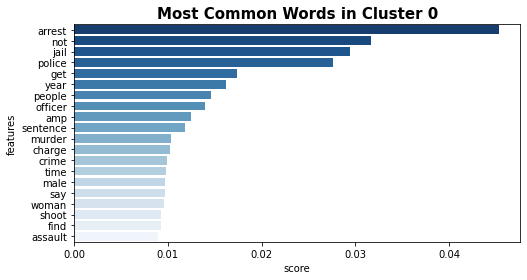

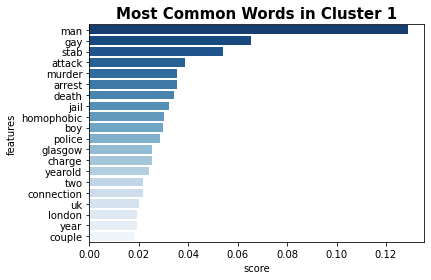

In [ ]:
n_feats = 20 #no of features
final_df_array = final_tf_idf_lem.to_numpy()
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, n_feats, 'lemmatized') #returns top 20 terms commonly used

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

#function to generate the word cloud
def generateWordClouds(centroids, type):
    wordcloud = WordCloud(max_font_size=300, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure(figsize=(10, 6))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

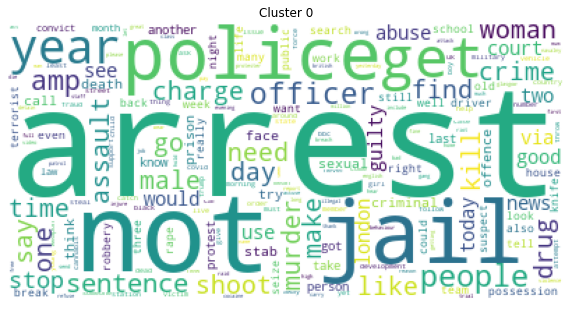

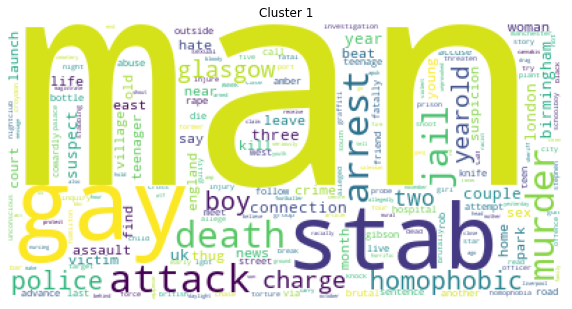

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_) #centroids
centroids.columns = final_tf_idf_lem.columns
generateWordClouds(centroids, 'lemmatized')

Looking at the word cloud of each cluster. We assumed Cluster 0 is representing crime tweets. <br>
Since we already have a manually labelled train dataset lets compare it with the kmeans predicted lables

In [ ]:
# Assigning the cluster labels
labels = kmeans.labels_ 

# Manually labelled labels
tweet_df['Prediction_lem'] = labels
tweet_df.to_csv("KMeans_Prediction.csv", index=False)

In [ ]:
#function to calculate the performance measures
def evaluation_measures(pred_column_name, yes_cluster_value, no_cluster_value):

    y_lem = tweet_df["Category"]

    # Calculating the number of samples correctly labelled
    correct_labelled_2 = sum(y_lem == labels)

    print("=> %d/%d were correctly labelled." % (correct_labelled_2, y_lem.size))

    print("----------------------------------------")

    correct_df = tweet_df[tweet_df['Category'] == tweet_df[pred_column_name]]
    TP_df = correct_df[correct_df[pred_column_name] == yes_cluster_value] 
    TN_df = correct_df[correct_df[pred_column_name] == no_cluster_value] 

    TotalYes = sum(tweet_df[pred_column_name]==yes_cluster_value) 
    TotalNo = sum(tweet_df[pred_column_name]==no_cluster_value) 

    TP = len(TP_df)
    TN = len(TN_df)
    FP = TotalNo - len(TN_df)
    FN = TotalYes - len(TP_df)

    print('True Positives = ', TP)
    print('True Negatives = ', TN)
    print('False Positives = ', FP)
    print('False Negatives = ', FN)

    print("----------------------------------------")

    Accuracy = ((TP + TN) / (TP + FN + TN + FP))
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN))
    F_Measure = ((2 * Precision * Recall) / (Precision + Recall))
    Specifity = TN / (TN + FP)
    Error_rate = (FP + FN) / (TP + TN + FP + FN)

    print('Accuracy -> %.4f' % Accuracy)
    print('Precision - -> %.4f' % Precision)
    print('Recall / Sensitivity -> %.4f' % Recall)
    print('F1-Score -> %.4f' % F_Measure)
    print('Specifity -> %.4f' % Specifity)
    print('Error Rate -> %.4f' % Error_rate)

In [ ]:
print("------------------ PERFORMANCE FOR KMEANS - LEMMATIZED ------------------ ")
evaluation_measures("Prediction_lem", 0, 1) #crime=cluster 0, #non-crime-cluster 1
print("Training time ", lem_trainingtime, " seconds")

------------------ PERFORMANCE FOR KMEANS - LEMMATIZED ------------------ 
=> 897/1340 were correctly labelled.
----------------------------------------
True Positives =  651
True Negatives =  246
False Positives =  19
False Negatives =  424
----------------------------------------
Accuracy -> 0.6694
Precision - -> 0.9716
Recall / Sensitivity -> 0.6056
F1-Score -> 0.7461
Specifity -> 0.9283
Error Rate -> 0.3306
Training time  4.210901498794556  seconds


# **K-Means Clustering With Stemming**

In [ ]:
#TF-IFD for stemmed tweets
vectorizer = TfidfVectorizer()
tf_idf_stem = vectorizer.fit_transform(tweet_df['stemming_tweet'])
final_tf_idf_stem = pd.DataFrame(data = tf_idf_stem.toarray(), columns=vectorizer.get_feature_names())

# first 5 words with highest weight on document 0:
final_tf_idf_stem.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339
hostel,0.285239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
savag,0.285239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
assail,0.269835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fled,0.269835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
luckili,0.269835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Perform K-means algorithm with 2 clusters
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
t2 = time.time()
prediction = kmeans.fit_predict(final_tf_idf_stem)
stem_trainingtime = time.time()-t2
prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

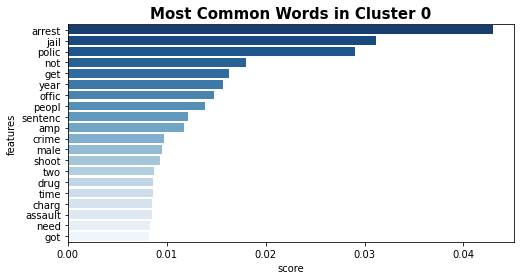

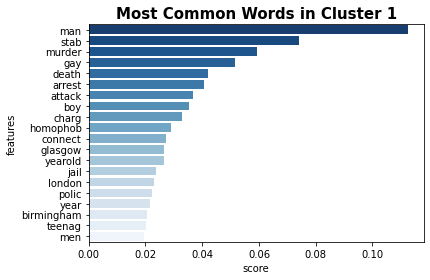

In [ ]:
n_feats = 20 #20 features
final_df_array = final_tf_idf_stem.to_numpy()
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, n_feats, 'stemming') #plotting the histogram for the commonly occuring terms

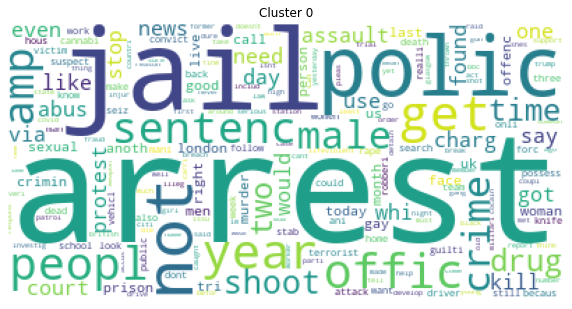

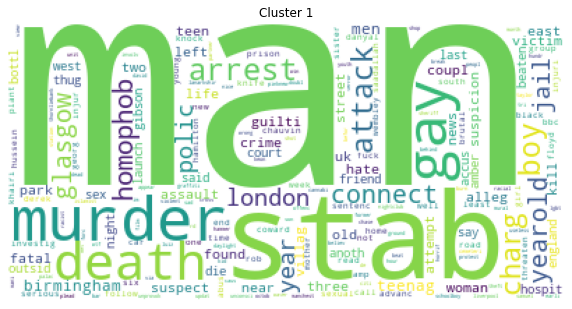

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_) #centroids
centroids.columns = final_tf_idf_stem.columns
generateWordClouds(centroids, 'stemming') #word cloud

Here also we assumed cluster 0 is representing crime and cluster 1 represents non-crime

In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
tweet_df = pd.read_csv("KMeans_Prediction.csv")
tweet_df['Prediction_stem'] = labels
tweet_df.to_csv("KMeans_Prediction.csv", index=False)

In [ ]:
print("------------------ PERFORMANCE FOR KMEANS - STEMMING ------------------ ")
evaluation_measures("Prediction_stem", 0, 1)#crime=cluster 0, #non-crime-cluster 1
print("Training time ", stem_trainingtime, " seconds")

------------------ PERFORMANCE FOR KMEANS - STEMMING ------------------ 
=> 855/1340 were correctly labelled.
----------------------------------------
True Positives =  641
True Negatives =  214
False Positives =  29
False Negatives =  456
----------------------------------------
Accuracy -> 0.6381
Precision - -> 0.9567
Recall / Sensitivity -> 0.5843
F1-Score -> 0.7255
Specifity -> 0.8807
Error Rate -> 0.3619
Training time  6.868032693862915  seconds


<h2>References : </h2>

https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b